## **Gradient Boosting in Regards to Heart Disease Classification, plus SHAP Visualisation for explaining the Models Nature**

In [66]:
%pip install pandas pd numpy scikit-learn matplotlib seaborn kagglehub shap xgboost lightgbm dask dask-ml distributed

Note: you may need to restart the kernel to use updated packages.


In [67]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import kagglehub

import shap
import xgboost as xgb
import lightgbm as lgb

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

import dask.dataframe as dd
from dask.distributed import Client
from dask_ml.model_selection import GridSearchCV as DaskGridSearchCV
import dask.array as da

import warnings

warnings.filterwarnings('ignore')

In [68]:
path = kagglehub.dataset_download("redwankarimsony/heart-disease-data")

print("Path to dataset files:", path)

Path to dataset files: /Users/sandymacdonald/.cache/kagglehub/datasets/redwankarimsony/heart-disease-data/versions/6


In [69]:
heart_data = path + "/heart_disease_uci.csv"

In [70]:
heart_disease_df = pd.read_csv(heart_data)

In [71]:
heart_disease_df.head()

,id,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num
0,1,63,Male,Cleveland,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0.0,fixed defect,0
1,2,67,Male,Cleveland,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,3.0,normal,2
2,3,67,Male,Cleveland,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,flat,2.0,reversable defect,1
3,4,37,Male,Cleveland,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,downsloping,0.0,normal,0
4,5,41,Female,Cleveland,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,upsloping,0.0,normal,0


In [72]:
heart_disease_df.shape

(920, 16)

In [73]:
heart_disease_df["num"] = heart_disease_df["num"].apply(lambda x: 1 if x > 0 else 0)

In [74]:
heart_disease_df.head()

,id,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num
0,1,63,Male,Cleveland,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0.0,fixed defect,0
1,2,67,Male,Cleveland,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,3.0,normal,1
2,3,67,Male,Cleveland,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,flat,2.0,reversable defect,1
3,4,37,Male,Cleveland,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,downsloping,0.0,normal,0
4,5,41,Female,Cleveland,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,upsloping,0.0,normal,0


In [75]:
heart_disease_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 920 entries, 0 to 919
Data columns (total 16 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        920 non-null    int64  
 1   age       920 non-null    int64  
 2   sex       920 non-null    object 
 3   dataset   920 non-null    object 
 4   cp        920 non-null    object 
 5   trestbps  861 non-null    float64
 6   chol      890 non-null    float64
 7   fbs       830 non-null    object 
 8   restecg   918 non-null    object 
 9   thalch    865 non-null    float64
 10  exang     865 non-null    object 
 11  oldpeak   858 non-null    float64
 12  slope     611 non-null    object 
 13  ca        309 non-null    float64
 14  thal      434 non-null    object 
 15  num       920 non-null    int64  
dtypes: float64(5), int64(3), object(8)
memory usage: 115.1+ KB


In [76]:
heart_disease_df = heart_disease_df.drop(columns=["id"])

heart_disease_df.head()

,age,sex,dataset,cp,trestbps,chol,fbs,restecg,thalch,exang,oldpeak,slope,ca,thal,num
0,63,Male,Cleveland,typical angina,145.0,233.0,True,lv hypertrophy,150.0,False,2.3,downsloping,0.0,fixed defect,0
1,67,Male,Cleveland,asymptomatic,160.0,286.0,False,lv hypertrophy,108.0,True,1.5,flat,3.0,normal,1
2,67,Male,Cleveland,asymptomatic,120.0,229.0,False,lv hypertrophy,129.0,True,2.6,flat,2.0,reversable defect,1
3,37,Male,Cleveland,non-anginal,130.0,250.0,False,normal,187.0,False,3.5,downsloping,0.0,normal,0
4,41,Female,Cleveland,atypical angina,130.0,204.0,False,lv hypertrophy,172.0,False,1.4,upsloping,0.0,normal,0


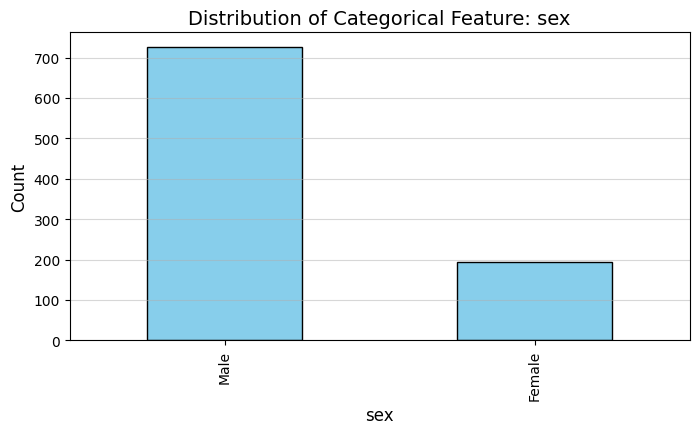

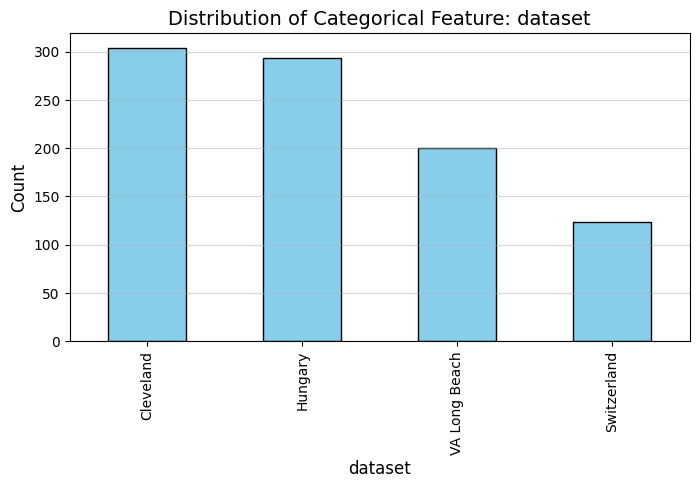

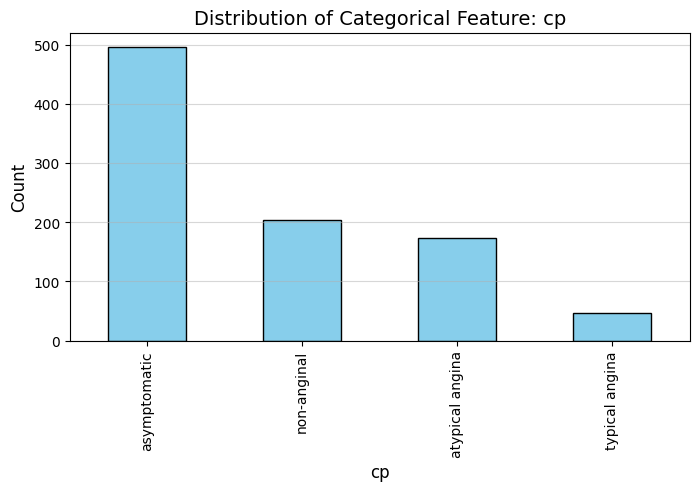

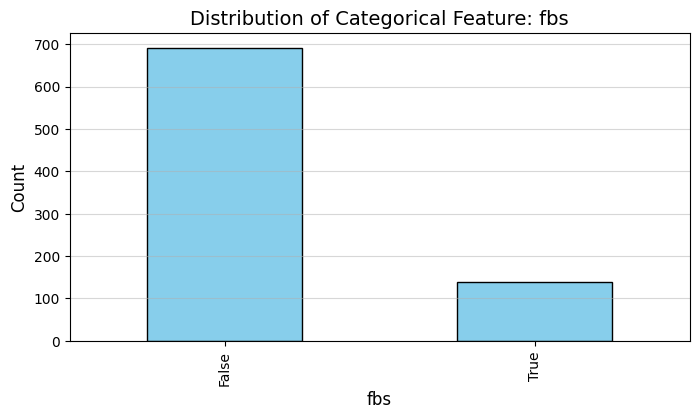

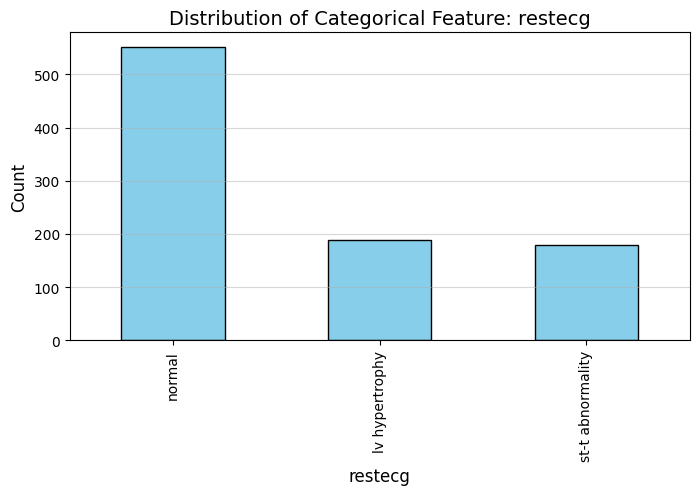

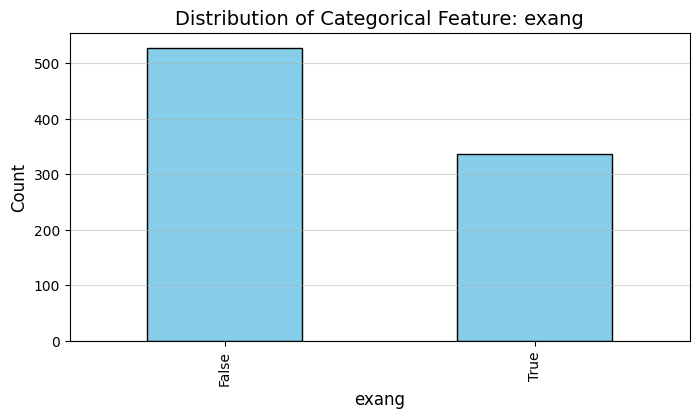

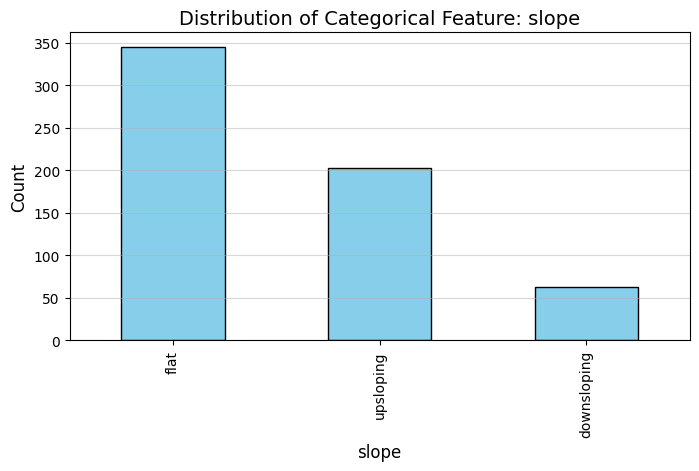

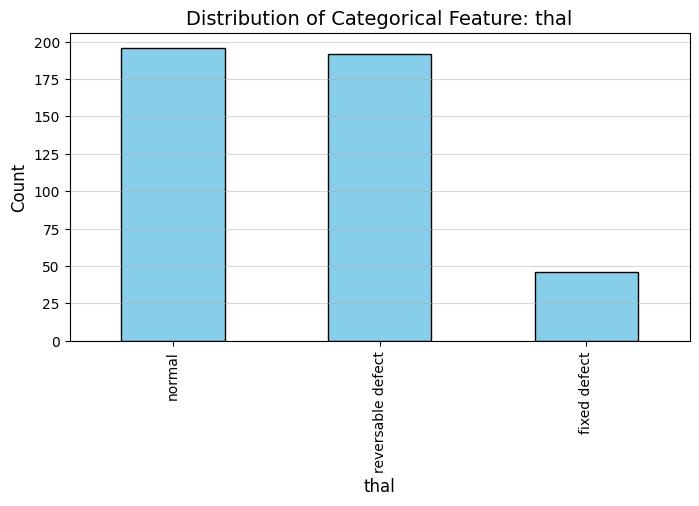

In [77]:
categorical_cols = heart_disease_df.select_dtypes(include=['object']).columns.tolist()

for col in categorical_cols:
    plt.figure(figsize=(8, 4))

    heart_disease_df[col].value_counts().plot(kind='bar', color='skyblue', edgecolor='black')

    plt.title(f'Distribution of Categorical Feature: {col}', fontsize=14)
    plt.xlabel(col, fontsize=12)
    plt.ylabel('Count', fontsize=12)
    plt.grid(axis='y', alpha=0.5)

    plt.show()

In [78]:
categorical_cols = heart_disease_df.select_dtypes(include=['object']).columns.tolist()

categorical_cols

['sex', 'dataset', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'thal']

In [79]:
heart_disease_df = pd.get_dummies(heart_disease_df, columns=categorical_cols, drop_first=True)

In [80]:
heart_disease_df.isnull().sum()

age                           0
trestbps                     59
chol                         30
thalch                       55
oldpeak                      62
ca                          611
num                           0
sex_Male                      0
dataset_Hungary               0
dataset_Switzerland           0
dataset_VA Long Beach         0
cp_atypical angina            0
cp_non-anginal                0
cp_typical angina             0
fbs_True                      0
restecg_normal                0
restecg_st-t abnormality      0
exang_True                    0
slope_flat                    0
slope_upsloping               0
thal_normal                   0
thal_reversable defect        0
dtype: int64

In [81]:
missing_threshold = 0.5

for col in heart_disease_df.columns:
    missing_fraction = heart_disease_df[col].isnull().mean()

    if missing_fraction > missing_threshold:
        heart_disease_df.drop(columns=[col], inplace=True)

    else:
        if heart_disease_df[col].dtype in [np.float64, np.int64]:
            heart_disease_df[col] = heart_disease_df[col].fillna(heart_disease_df[col].median())

        else:
            heart_disease_df[col] = heart_disease_df[col].fillna(heart_disease_df[col].mode()[0])

heart_disease_df.isnull().sum()
heart_disease_df.head()

,age,trestbps,chol,thalch,oldpeak,num,sex_Male,dataset_Hungary,dataset_Switzerland,dataset_VA Long Beach,...,cp_non-anginal,cp_typical angina,fbs_True,restecg_normal,restecg_st-t abnormality,exang_True,slope_flat,slope_upsloping,thal_normal,thal_reversable defect
0,63,145.0,233.0,150.0,2.3,0,True,False,False,False,...,False,True,True,False,False,False,False,False,False,False
1,67,160.0,286.0,108.0,1.5,1,True,False,False,False,...,False,False,False,False,False,True,True,False,True,False
2,67,120.0,229.0,129.0,2.6,1,True,False,False,False,...,False,False,False,False,False,True,True,False,False,True
3,37,130.0,250.0,187.0,3.5,0,True,False,False,False,...,True,False,False,True,False,False,False,False,True,False
4,41,130.0,204.0,172.0,1.4,0,False,False,False,False,...,False,False,False,False,False,False,False,True,True,False


In [82]:
numerical_cols = heart_disease_df.select_dtypes(include=[np.float64, np.int64]).columns.tolist()

numerical_cols.remove("num")

scaler = StandardScaler()

heart_disease_df[numerical_cols] = scaler.fit_transform(heart_disease_df[numerical_cols])

heart_disease_df.head()

,age,trestbps,chol,thalch,oldpeak,num,sex_Male,dataset_Hungary,dataset_Switzerland,dataset_VA Long Beach,...,cp_non-anginal,cp_typical angina,fbs_True,restecg_normal,restecg_st-t abnormality,exang_True,slope_flat,slope_upsloping,thal_normal,thal_reversable defect
0,1.007386,0.705176,0.303643,0.489727,1.368109,0,True,False,False,False,...,False,True,True,False,False,False,False,False,False,False
1,1.432034,1.518569,0.789967,-1.181478,0.611589,1,True,False,False,False,...,False,False,False,False,False,True,True,False,True,False
2,1.432034,-0.650479,0.266939,-0.345875,1.651804,1,True,False,False,False,...,False,False,False,False,False,True,True,False,False,True
3,-1.752828,-0.108217,0.459634,1.961979,2.502889,0,True,False,False,False,...,True,False,False,True,False,False,False,False,True,False
4,-1.328180,-0.108217,0.037541,1.365120,0.517024,0,False,False,False,False,...,False,False,False,False,False,False,False,True,True,False


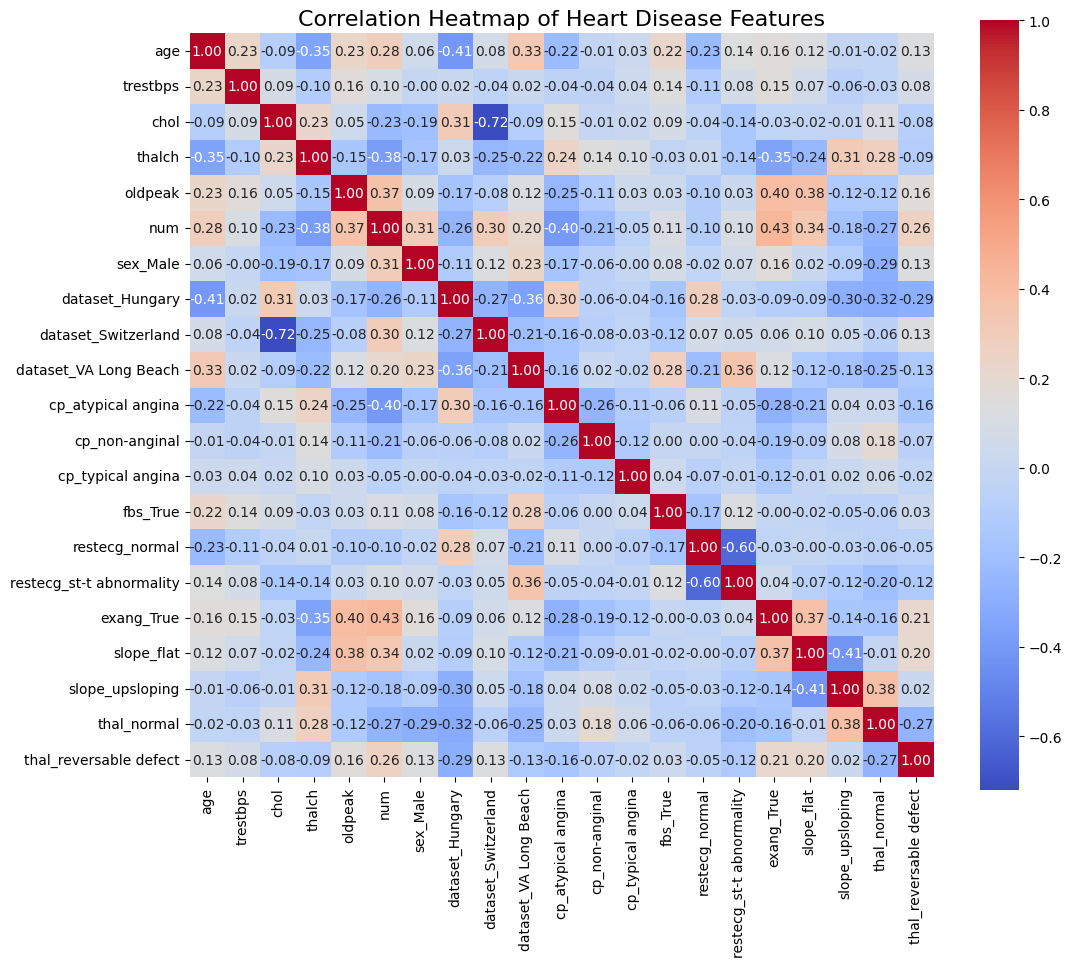

In [83]:
plt.figure(figsize=(12, 10))

correlation_matrix = heart_disease_df.corr()

sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)

plt.title('Correlation Heatmap of Heart Disease Features', fontsize=16)

plt.show()

In [84]:
X = heart_disease_df.drop("num", axis=1)

y = heart_disease_df["num"]

In [85]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=65)

### **XGBoost**

In [86]:
xgb_clf = xgb.XGBClassifier(eval_metric='logloss', random_state=65)

xgb_clf.fit(X_train, y_train)

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'


In [87]:
y_pred_xgb = xgb_clf.predict(X_test)

print(confusion_matrix(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb))
print('ROC AUC:', roc_auc_score(y_test, y_pred_xgb))

[[64 16]
 [21 83]]
              precision    recall  f1-score   support

           0       0.75      0.80      0.78        80
           1       0.84      0.80      0.82       104

    accuracy                           0.80       184
   macro avg       0.80      0.80      0.80       184
weighted avg       0.80      0.80      0.80       184

ROC AUC: 0.7990384615384617


In [ ]:
# XGBoost hyperparameter grid search
xgb_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.8, 0.9, 1.0],
    'min_child_weight': [1, 3, 5]
}

In [89]:
xgb_grid = GridSearchCV(xgb.XGBClassifier(random_state=65),
                      xgb_param_grid,
                      cv=10,
                      scoring='roc_auc',
                      n_jobs=-1,
                      verbose=1)

xgb_grid.fit(X_train, y_train)

print('Best XGBoost Params:', xgb_grid.best_params_)
print('Best XGBoost CV ROC AUC:', xgb_grid.best_score_)

Fitting 10 folds for each of 324 candidates, totalling 3240 fits
Best XGBoost Params: {'learning_rate': 0.05, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 0.8}
Best XGBoost CV ROC AUC: 0.8967278053128126


## **LightGBM**

In [90]:
lgb_clf = lgb.LGBMClassifier(random_state=65)

lgb_clf.fit(X_train, y_train)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 405, number of negative: 331
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000328 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 736, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.550272 -> initscore=0.201769
[LightGBM] [Info] Start training from score 0.201769
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

,boosting_type,'gbdt'
,num_leaves,31
,max_depth,-1
,learning_rate,0.1
,n_estimators,100
,subsample_for_bin,200000
,objective,None
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


In [91]:
y_pred_lgb = lgb_clf.predict(X_test)

print(confusion_matrix(y_test, y_pred_lgb))
print(classification_report(y_test, y_pred_lgb))
print('ROC AUC:', roc_auc_score(y_test, y_pred_lgb))

[[63 17]
 [19 85]]
              precision    recall  f1-score   support

           0       0.77      0.79      0.78        80
           1       0.83      0.82      0.83       104

    accuracy                           0.80       184
   macro avg       0.80      0.80      0.80       184
weighted avg       0.81      0.80      0.80       184

ROC AUC: 0.8024038461538461


In [92]:
# LightGBM hyperparameter grid search
lgb_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [-1, 5, 10],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.8, 0.9, 1.0],
    'min_child_samples': [5, 10, 20]
}

In [ ]:
lgb_grid = RandomizedSearchCV(
    lgb.LGBMClassifier(random_state=65),
    lgb_param_grid,
    n_iter=20,
    cv=10,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1,
    random_state=65
)

lgb_grid.fit(X_train, y_train)

print('Best LightGBM Params:', lgb_grid.best_params_)
print('Best LightGBM CV ROC AUC:', lgb_grid.best_score_)

Fitting 10 folds for each of 20 candidates, totalling 200 fits
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 365, number of negative: 297
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000326 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 357
[LightGBM] [Info] Number of data points in the train set: 662, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.551360 -> initscore=0.206165
[LightGBM] [Info] Start training from score 0.206165
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 364, number of negative: 298
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 364, number of negative: 298
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of test

### **LightGBM Distributed Learning**

In [ ]:
# LightGBM with distributed learning using Dask

# Initialize Dask client for distributed computing
client = Client(n_workers=2, threads_per_worker=2, memory_limit='2GB')

print(client)
print(f"Dashboard link: {client.dashboard_link}")

In [ ]:
# Convert data to Dask arrays for distributed processing

X_train_dask = da.from_array(X_train.values, chunks=(len(X_train)//2, X_train.shape[1]))

y_train_dask = da.from_array(y_train.values, chunks=len(y_train)//2)

X_test_dask = da.from_array(X_test.values, chunks=(len(X_test)//2, X_test.shape[1]))

print(f"Training data partitions: {X_train_dask.npartitions}")
print(f"Training data shape: {X_train_dask.shape}")

In [ ]:
# Train LightGBM with distributed learning
lgb_dist_clf = lgb.LGBMClassifier(
    random_state=65,
    n_jobs=-1  # Use all available cores
)

# Fit on the full training data
lgb_dist_clf.fit(X_train, y_train)

# Predictions
y_pred_lgb_dist = lgb_dist_clf.predict(X_test)

print("LightGBM Distributed Learning Results:")
print(confusion_matrix(y_test, y_pred_lgb_dist))
print(classification_report(y_test, y_pred_lgb_dist))
print('ROC AUC:', roc_auc_score(y_test, y_pred_lgb_dist))

In [ ]:
lgb_dist_grid = DaskGridSearchCV(
    lgb.LGBMClassifier(random_state=65, n_jobs=1),
    lgb_param_grid,
    cv=10,
    scoring='roc_auc'
)

lgb_dist_grid.fit(X_train, y_train)

print('Best LightGBM Distributed Params:', lgb_dist_grid.best_params_)
print('Best LightGBM Distributed CV ROC AUC:', lgb_dist_grid.best_score_)

In [ ]:
# Close the Dask client when done
client.close()

### **SHAP**

In [ ]:
# SHAP explanation for XGBoost
explainer_xgb = shap.TreeExplainer(xgb_clf)

shap_values_xgb = explainer_xgb.shap_values(X_test.values)

shap.summary_plot(shap_values_xgb, X_test, show=False)

plt.title('SHAP Summary Plot for XGBoost')

plt.show()

In [ ]:
# SHAP explanation for LightGBM
explainer_lgb = shap.TreeExplainer(lgb_clf)

shap_values_lgb = explainer_lgb.shap_values(X_test.values)

# Handle the list output for binary classification
if isinstance(shap_values_lgb, list):
    shap_values_lgb = shap_values_lgb[1]

shap.summary_plot(shap_values_lgb, X_test, show=False)

plt.title('SHAP Summary Plot for LightGBM')

plt.show()

In [ ]:
# SHAP explanation for LightGBM with Dask Distributed Learning
explainer_lgb_dist = shap.TreeExplainer(lgb_dist_clf)

shap_values_lgb_dist = explainer_lgb_dist.shap_values(X_test.values)

# Handle the list output for binary classification
if isinstance(shap_values_lgb_dist, list):
    shap_values_lgb_dist = shap_values_lgb_dist[1]

shap.summary_plot(shap_values_lgb_dist, X_test, show=False)

plt.title('SHAP Summary Plot for LightGBM with Dask')

plt.show()